<a href="https://colab.research.google.com/github/Comfortxble/UROP-ABCD/blob/main/DT_sstfMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load Packages**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/vir_env/lib/python3.13/site-packages")

In [ ]:
#Loading other packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.model_selection import RepeatedStratifiedKFold

# **Combined Psychosocial and fMRI**

## **Load Data + Data Separation**

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/UROP Data/sa_ppc_sstfMRI_train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/UROP Data/sa_ppc_sstfMRI_test.csv")

In [ ]:
y = df['SuicideAttempt']
X = df.drop(['SuicideAttempt', 'subjectkey'], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
# stratify=y to mediate data imbalance

y_test = df_test['SuicideAttempt']
X_test = df_test.drop(['SuicideAttempt', 'subjectkey'], axis=1)

In [ ]:
# Questionaire ONLY
X_train_q = X_train.iloc[:, 0:130]
X_valid_q = X_valid.iloc[:, 0:130]
X_test_q = X_test.iloc[:, 0:130]

# fMRI ONLY
X_train_mri = X_train.iloc[:, 130::]
X_valid_mri = X_valid.iloc[:, 130::]
X_test_mri = X_test.iloc[:, 130::]

In [ ]:
# is the data balanced? since there's only 1s and 0s, can divide sum(y) by total number of observations
print(sum(y_train)/len(y_train))
print(sum(y_valid)/len(y_valid))
print(sum(y_test)/len(y_test)) # it's balanced in the test set

0.006847751654873316
0.006386861313868613
0.45


## **Preliminary Model**

In [ ]:
clf = DecisionTreeClassifier(random_state=1, class_weight='balanced')
clf.fit(X_train, y_train)
predict = clf.predict(X_valid)
print(clf.score(X_valid, y_valid))

0.9781021897810219


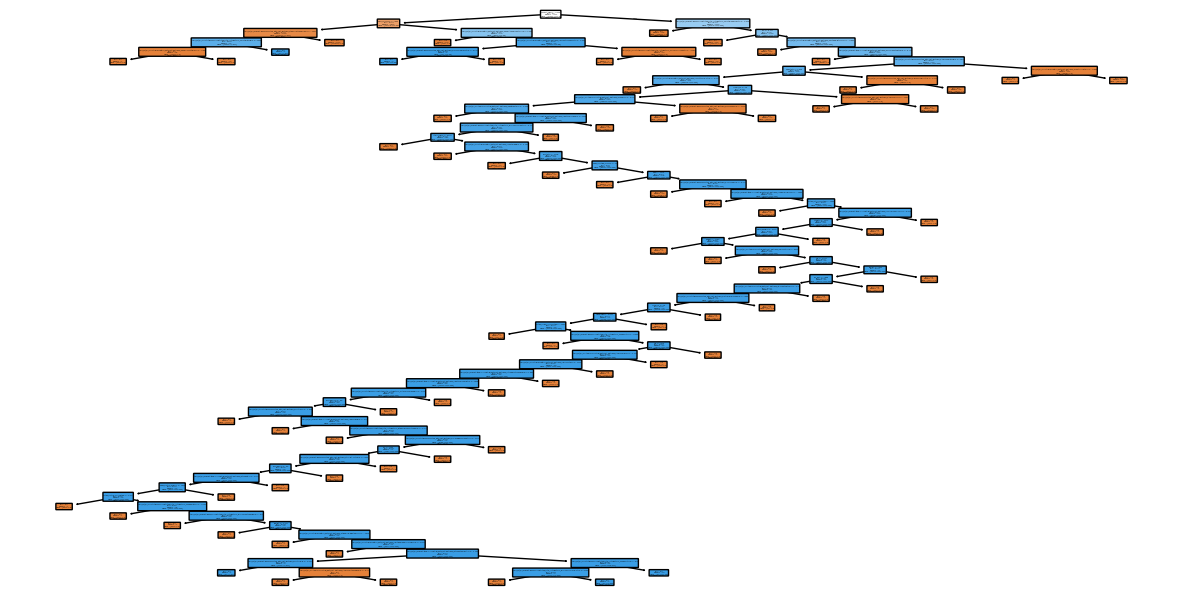

In [ ]:
plt.figure(figsize=(15,7.5)) # (width, height)
plot_tree(clf,
          feature_names=X_train.columns,
          class_names=['No SA', 'Yes SA'],
          filled=True,
          rounded=True)
plt.show()

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_valid, predict, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.99      0.98      0.99      1089
         Yes       0.00      0.00      0.00         7

    accuracy                           0.98      1096
   macro avg       0.50      0.49      0.49      1096
weighted avg       0.99      0.98      0.98      1096



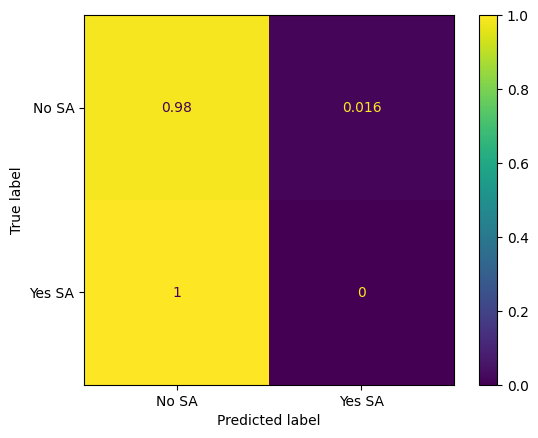

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf, X_valid, y_valid, normalize='true',
                                      display_labels=["No SA", "Yes SA"])

In [ ]:
predict = clf.predict(X_test)
print(metrics.classification_report(y_test, predict, target_names=['No SA', 'Yes SA']))

              precision    recall  f1-score   support

       No SA       0.55      1.00      0.71        11
      Yes SA       0.00      0.00      0.00         9

    accuracy                           0.55        20
   macro avg       0.28      0.50      0.35        20
weighted avg       0.30      0.55      0.39        20



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


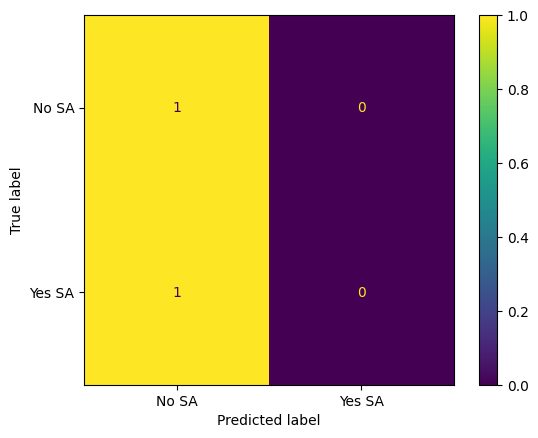

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, normalize='true',
                                      display_labels=["No SA", "Yes SA"])

In [ ]:
feature_names = X_train.columns
importances = clf.feature_importances_
feature_importance = pd.DataFrame(importances, index=feature_names, columns=['importances'])
feature_importance = feature_importance.sort_values('importances', ascending=False)

features = list(feature_importance[feature_importance['importances']>0].index)
len(features)

71

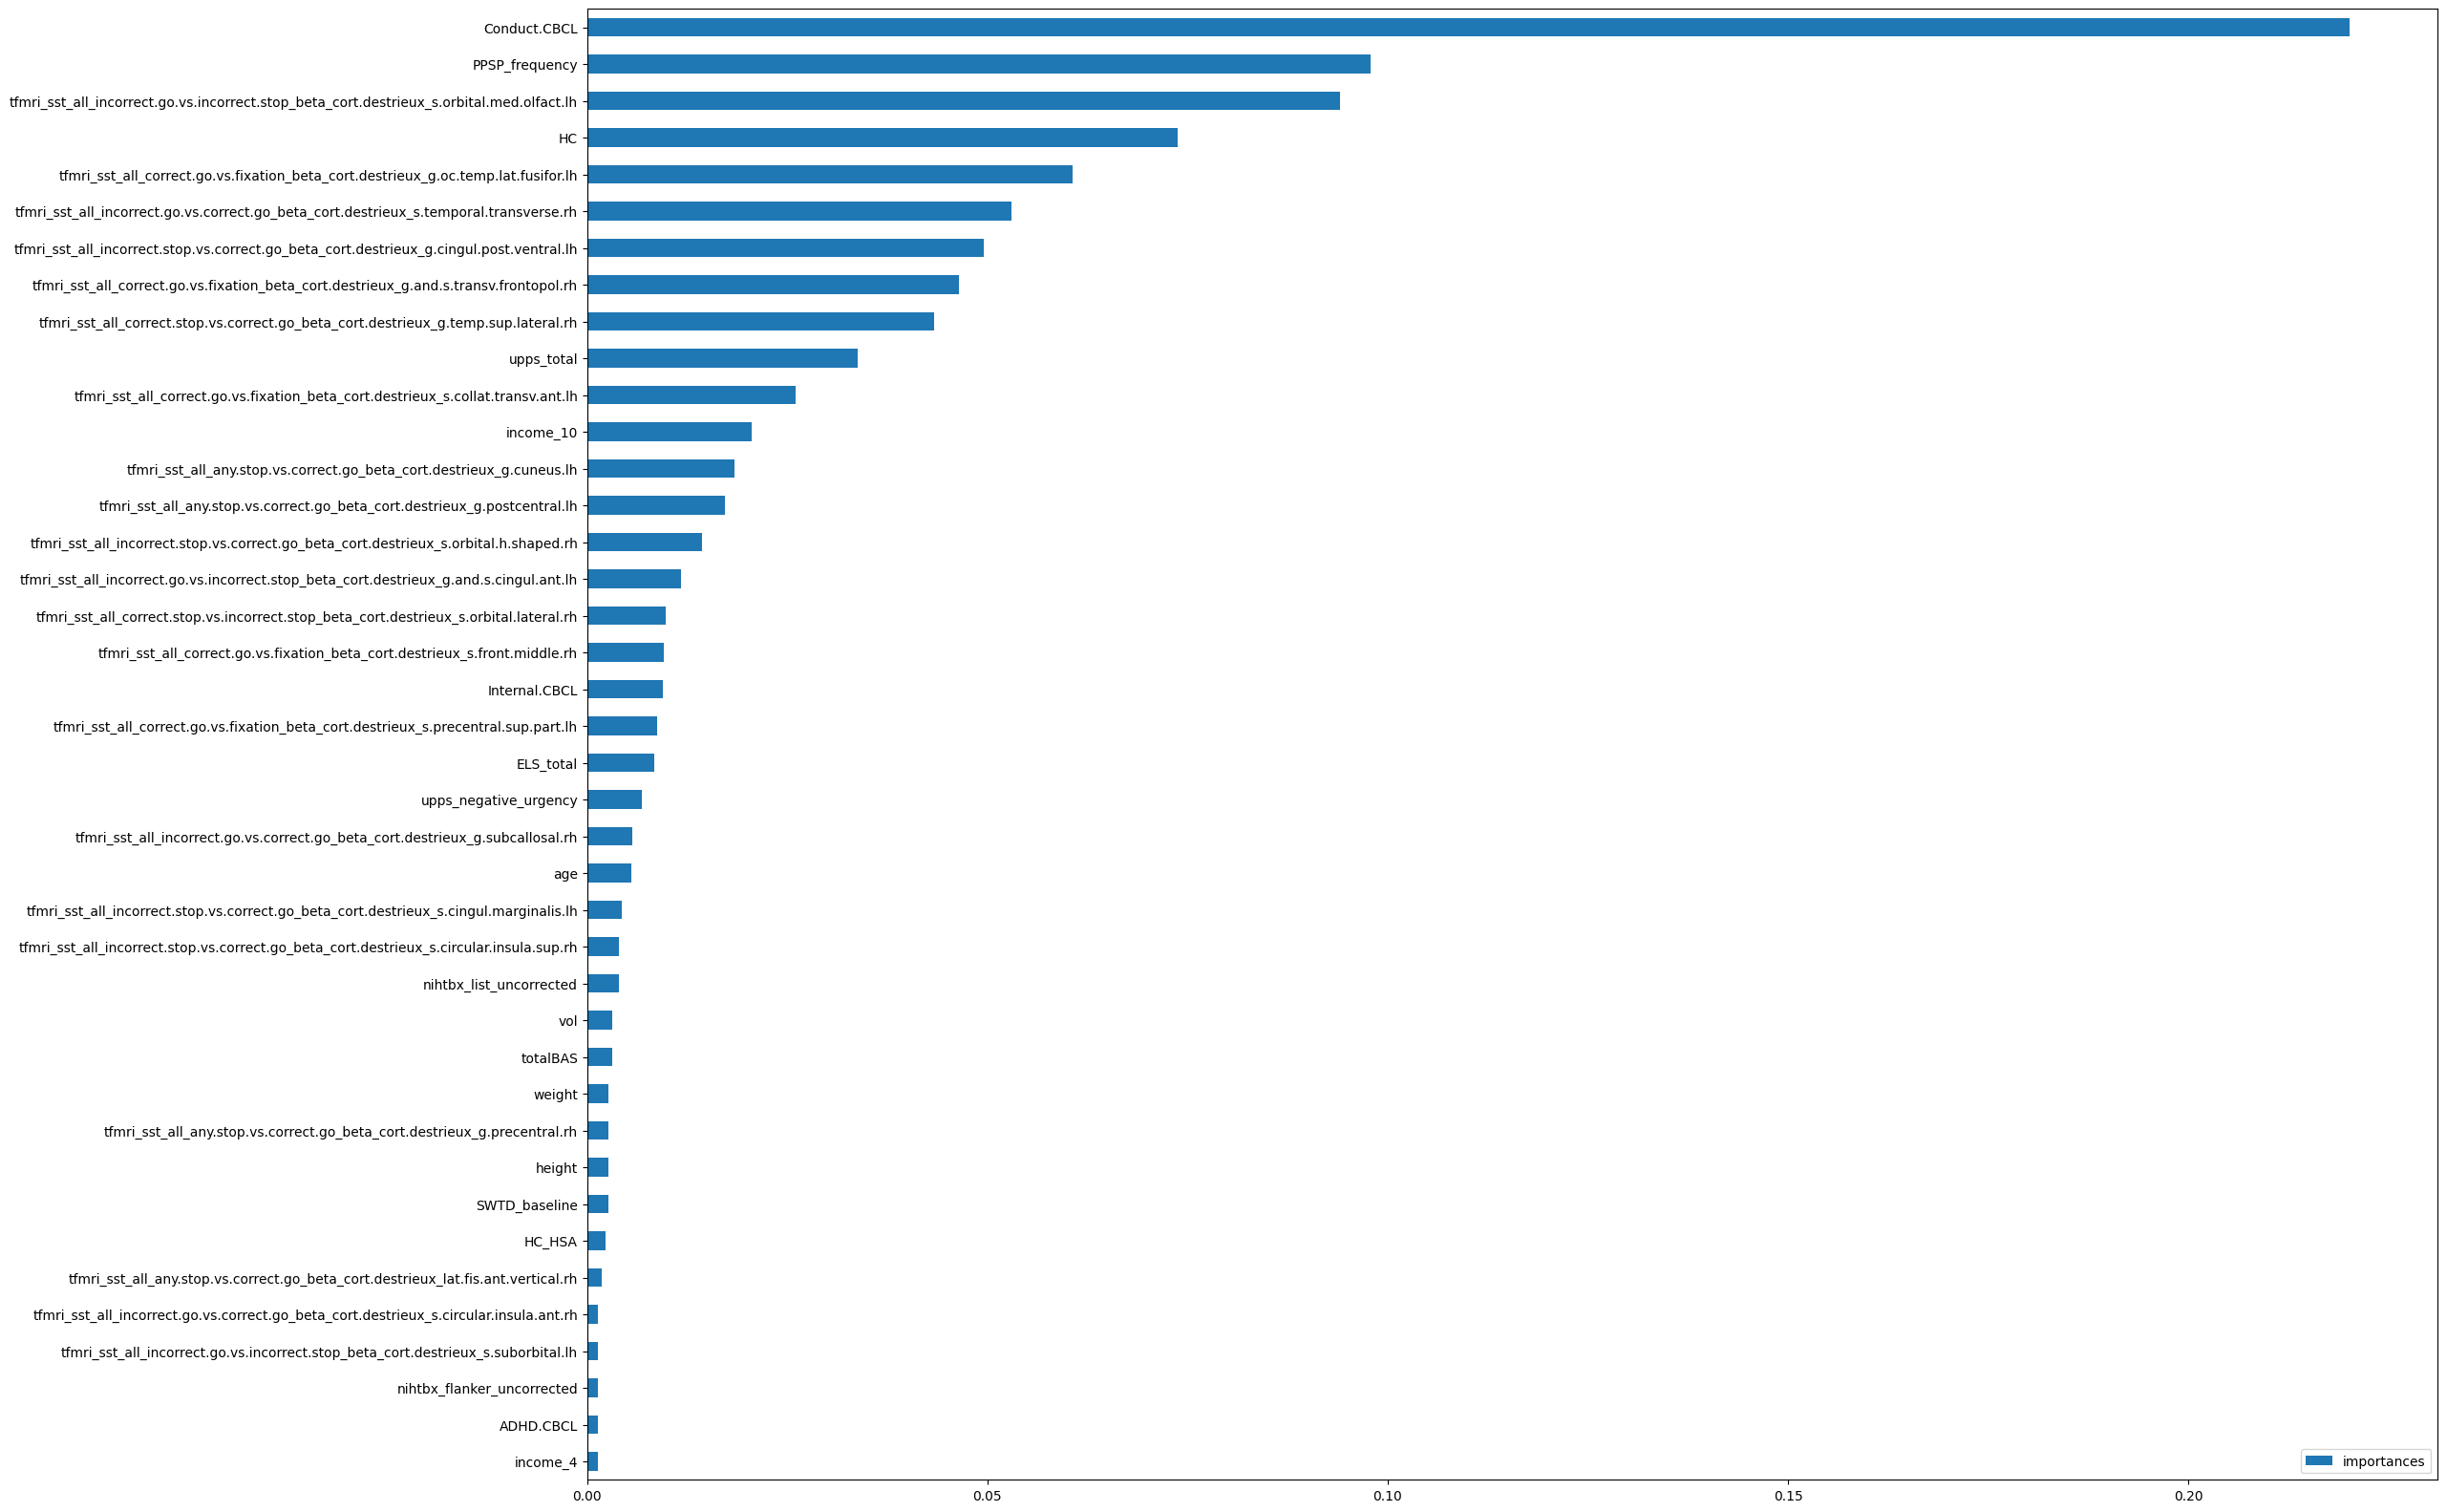

In [ ]:
FI_plot = feature_importance.head(40).plot(figsize=(25,20), kind='barh').invert_yaxis()

## **Cost Complexity Pruning**

### Visualizing Alpha Value

In [ ]:
path = clf.cost_complexity_pruning_path(X_train, y_train) # determine values for alpha
# extract different values of alpha vailable for the tree
ccp_alphas = path.ccp_alphas
# omit max value for alpha or else it would prune ALL leaves
ccp_alphas = ccp_alphas[:-1]

clf_dts = [] # create an array to put DTs into

# build a pruned tree for each value of alpha and store in the array
for ccp_alpha in ccp_alphas:
  clf = DecisionTreeClassifier(random_state=1, class_weight='balanced', ccp_alpha=ccp_alpha)
  clf.fit(X_train, y_train)
  clf_dts.append(clf)

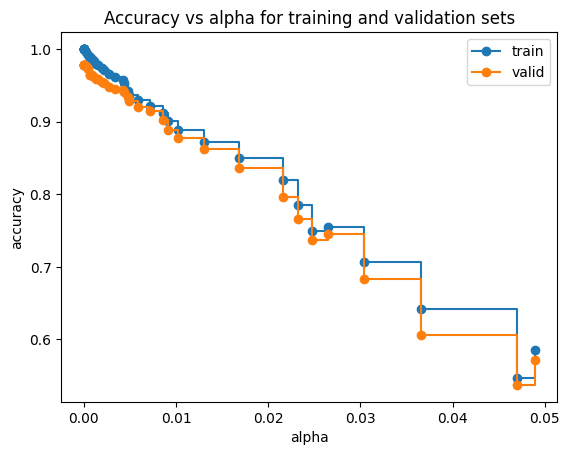

In [ ]:
# graph accuracy of the trees using training and testing dataset as a function of alpha
train_scores = [clf.score(X_train, y_train) for clf in clf_dts]
valid_scores = [clf.score(X_valid, y_valid) for clf in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validation sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker='o', label="valid", drawstyle="steps-post")
ax.legend()
plt.show()

### CV to Find Best Alpha

In [ ]:
param_grid = {'ccp_alpha': ccp_alphas}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
optimal_params = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=1, class_weight='balanced'),
    param_grid = param_grid,
    scoring = ['recall', 'f1', 'roc_auc'],
    n_jobs=-1,
    cv=cv,
    verbose=2,
    refit='roc_auc')

optimal_params.fit(X_train_q, y_train)

Fitting 30 folds for each of 39 candidates, totalling 1170 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=1),
             n_jobs=-1,
             param_grid={'ccp_alpha': array([0.00000000e+00, 4.66951996e-18, 1.49909452e-17, 3.47024434e-17,
       4.35964755e-15, 4.99613119e-15, 1.00687098e-14, 1.35979483e-14,
       2.28861152e-04, 4.53393809e-04, 6.7386...
       1.95895561e-03, 2.16096574e-03, 2.78345530e-03, 3.38923420e-03,
       4.19798848e-03, 4.33596266e-03, 4.74806708e-03, 4.90099980e-03,
       5.87530234e-03, 7.17690841e-03, 8.60107275e-03, 9.17542351e-03,
       1.02565233e-02, 1.30288571e-02, 1.68759445e-02, 2.16400161e-02,
       2.31924283e-02, 2.47849591e-02, 2.65078191e-02, 3.03396943e-02,
       3.66220596e-02, 4.69906008e-02, 4.89044838e-02])},
             refit='roc_auc', scoring=['recall', 'f1', 'roc_auc'], verbose=2)

In [ ]:
results_df = pd.DataFrame(optimal_params.cv_results_)
results_df['mean_metrics'] = results_df[['mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc']].mean(axis=1)

scoring_df = ['param_ccp_alpha', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc', 'mean_metrics']
# results_df[scoring_df]
sorted_df = results_df.sort_values(by=['mean_metrics'], ascending=False)
# sorted_df

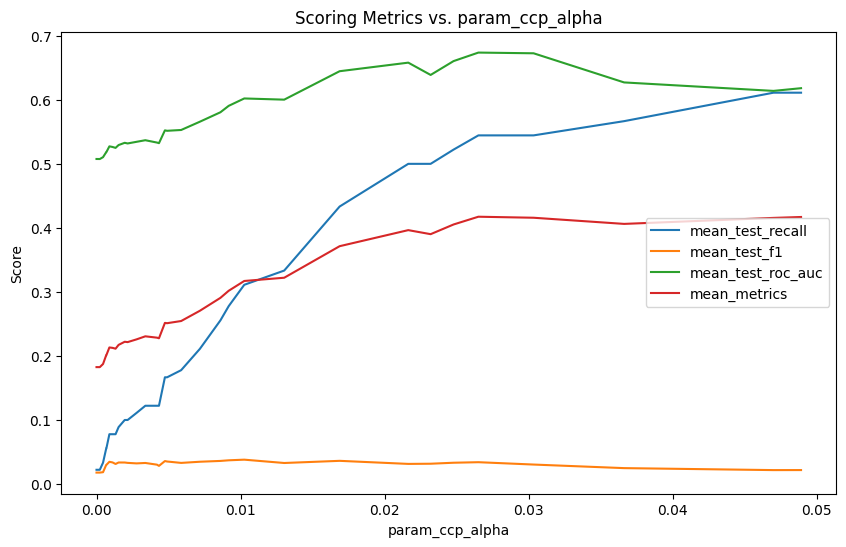

In [ ]:
scoring_metrics = ['mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc', 'mean_metrics']

fig, ax = plt.subplots(figsize=(10, 6))

for metric in scoring_metrics:
    ax.plot(results_df['param_ccp_alpha'], results_df[metric], label=metric)

ax.set_xlabel('param_ccp_alpha')
ax.set_ylabel('Score')
ax.set_title('Scoring Metrics vs. param_ccp_alpha')
ax.legend()
plt.show()

In [ ]:
optimal_params.best_params_
ideal_ccp_alpha = float(optimal_params.best_params_['ccp_alpha'])
ideal_ccp_alpha

0.026507819081134996

0.8090972880164755


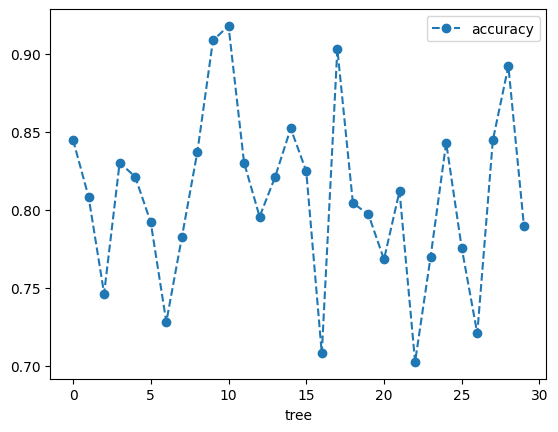

In [ ]:
# create the tree with ccp_alpha = ccp_alphas[-1]
clf = DecisionTreeClassifier(random_state=1, class_weight='balanced', ccp_alpha=ideal_ccp_alpha)

# the graph we drew suggested ONE value for alpha, but another set might suggested another optimal value...
scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
df = pd.DataFrame(data={'tree': range(30), 'accuracy': scores})

# for instance, if we do this with 30-fold CV, see how the accuracy varies by applying the same alpha to all of them
df.plot(x='tree', y='accuracy', marker='o', linestyle='--')
print(scores.mean())

0.5529079861111111


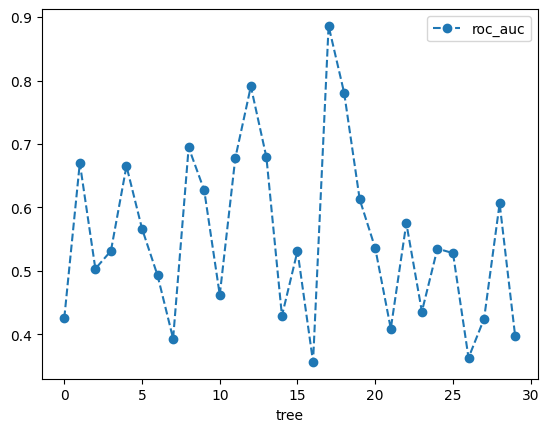

In [ ]:
scores = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
df = pd.DataFrame(data={'tree': range(30), 'roc_auc': scores})

df.plot(x='tree', y='roc_auc', marker='o', linestyle='--')
print(scores.mean())

## **Build, Evaluate, Draw, Interpret the Final DT**

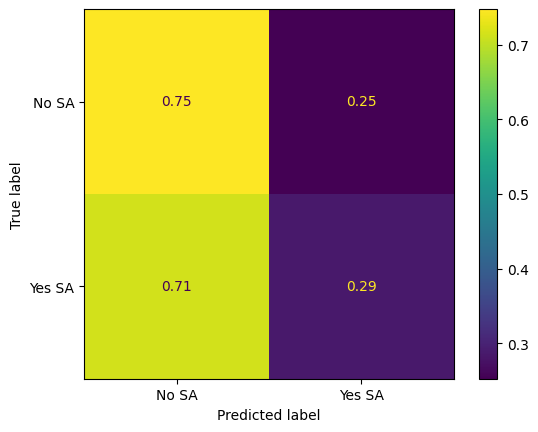

In [ ]:
# build and train new DT w/ optimal value for alpha
clf_dt_pruned = DecisionTreeClassifier(random_state=1, class_weight='balanced', ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned.fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(clf_dt_pruned, X_valid, y_valid, normalize='true',
                                      display_labels=["No SA", "Yes SA"])

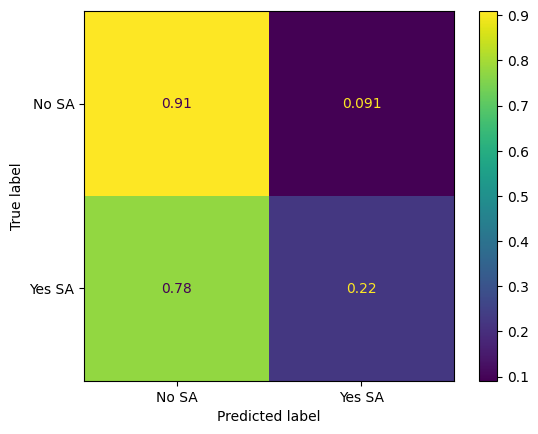

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf_dt_pruned, X_test, y_test, normalize='true',
                                      display_labels=["No SA", "Yes SA"])

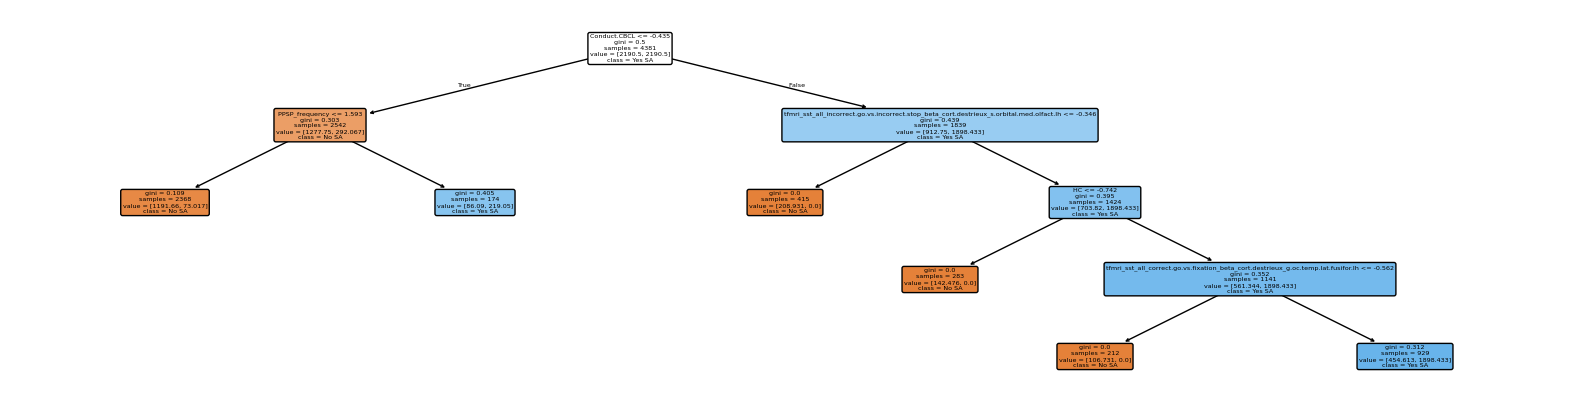

In [ ]:
# plot/draw the pruned tree
plt.figure(figsize=(20,5))
plt.title("Pruned Decision Tree")
plot_tree(clf_dt_pruned,
          feature_names=X_train.columns,
          class_names=["No SA", "Yes SA"],
          filled=True,
          rounded=True)
plt.show()

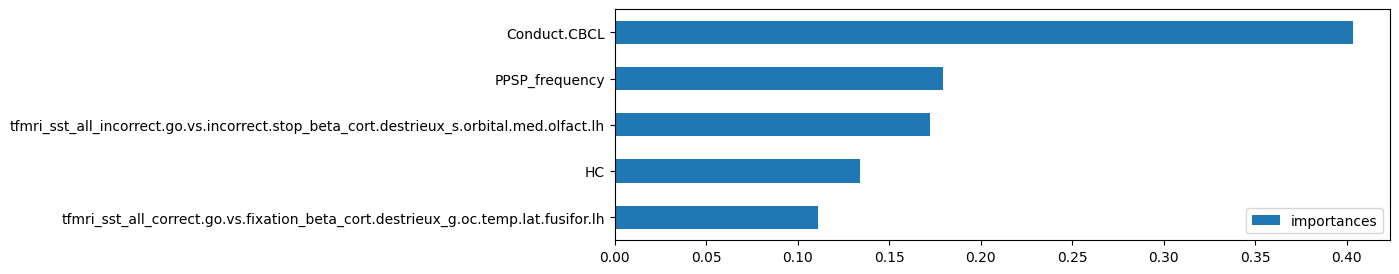

In [ ]:
feature_names = X_train.columns
importances = clf_dt_pruned.feature_importances_
feature_importance = pd.DataFrame(importances, index=feature_names, columns=['importances'])
feature_importance = feature_importance.sort_values('importances', ascending=False)

features = list(feature_importance[feature_importance['importances']>0].index)
FI_plot = feature_importance.head().plot(figsize=(10,3), kind='barh').invert_yaxis()

## **AUC ROC**

In [ ]:
from sklearn.metrics import roc_auc_score
predict_proba = clf_dt_pruned.predict_proba(X_valid)
roc_auc_score(y_valid, predict_proba[:, 1])

0.4897678079496262

In [ ]:
predict_proba = clf_dt_pruned.predict_proba(X_test)
roc_auc_score(y_test, predict_proba[:, 1])

0.5656565656565656

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr1, tpr1, thresholds1 = roc_curve(y_test, predict_proba[:,1])
auc1 = auc(fpr1, tpr1)

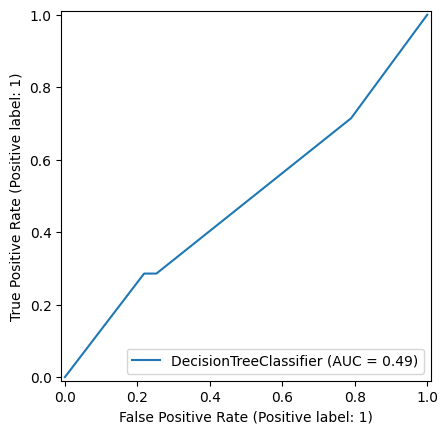

In [ ]:
metrics.RocCurveDisplay.from_estimator(clf_dt_pruned, X_valid, y_valid)

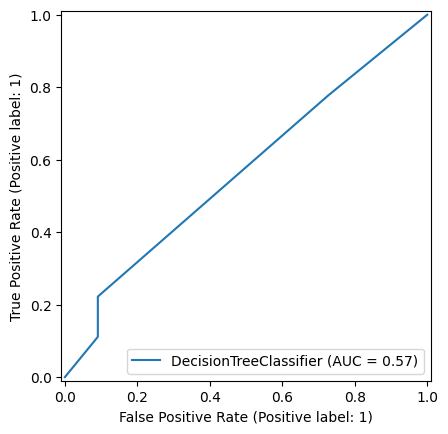

In [ ]:
metrics.RocCurveDisplay.from_estimator(clf_dt_pruned, X_test, y_test)

In [ ]:
predict = clf_dt_pruned.predict(X_valid)
print(metrics.classification_report(y_valid, predict, target_names=['No SA', 'Yes SA']))

              precision    recall  f1-score   support

       No SA       0.99      0.75      0.85      1089
      Yes SA       0.01      0.29      0.01         7

    accuracy                           0.74      1096
   macro avg       0.50      0.52      0.43      1096
weighted avg       0.99      0.74      0.85      1096



In [ ]:
predict = clf_dt_pruned.predict(X_test)
print(metrics.classification_report(y_test, predict, target_names=['No SA', 'Yes SA']))

              precision    recall  f1-score   support

       No SA       0.59      0.91      0.71        11
      Yes SA       0.67      0.22      0.33         9

    accuracy                           0.60        20
   macro avg       0.63      0.57      0.52        20
weighted avg       0.62      0.60      0.54        20



# **Psychosocial ONLY**

## Cost Complexity Pruning

### Visualizing Alpha Value

In [ ]:
path = clf.cost_complexity_pruning_path(X_train_q, y_train) # determine values for alpha
ccp_alphas = path.ccp_alphas
# omit max value for alpha or else it would prune ALL leaves
ccp_alphas = ccp_alphas[:-1]

clf_dts = [] # create an array to put DTs into

# build a pruned tree for each value of alpha and store in the array
for ccp_alpha in ccp_alphas:
  clf = DecisionTreeClassifier(random_state=1, class_weight='balanced', ccp_alpha=ccp_alpha)
  clf.fit(X_train_q, y_train)
  clf_dts.append(clf)
# print(ccp_alphas)

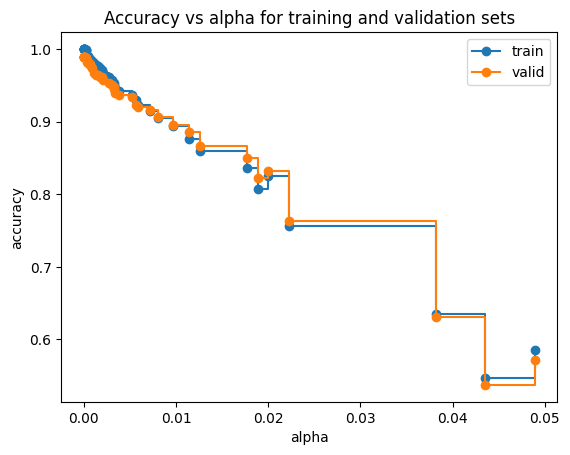

In [ ]:
# graph accuracy of the trees using training and testing dataset as a function of alpha
train_scores = [clf.score(X_train_q, y_train) for clf in clf_dts]
valid_scores = [clf.score(X_valid_q, y_valid) for clf in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validation sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker='o', label="valid", drawstyle="steps-post")
ax.legend()
plt.show()

### CV to Find Best Alpha

In [ ]:
param_grid = {'ccp_alpha': ccp_alphas}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
optimal_params = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=1, class_weight='balanced'),
    param_grid = param_grid,
    scoring = ['recall', 'f1', 'roc_auc'],
    n_jobs=-1,
    cv=cv,
    verbose=2,
    refit='roc_auc')

optimal_params.fit(X_train_q, y_train)

Fitting 30 folds for each of 45 candidates, totalling 1350 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=1),
             n_jobs=-1,
             param_grid={'ccp_alpha': array([0.00000000e+00, 1.00917767e-17, 2.27734785e-17, 3.32990358e-17,
       3.70074342e-17, 4.46028464e-17, 2.92572218e-16, 3.30770422e-16,
       1.14828141e-04, 2.28954666e-04, 2.2930...
       2.72444246e-03, 3.10154535e-03, 3.27503507e-03, 3.31758019e-03,
       3.40032768e-03, 3.84520435e-03, 5.18612821e-03, 5.68370930e-03,
       5.82616189e-03, 7.15229709e-03, 8.04880755e-03, 9.67693677e-03,
       1.14613181e-02, 1.25479076e-02, 1.76951379e-02, 1.88401189e-02,
       1.99475008e-02, 2.22687957e-02, 3.81549782e-02, 4.34630701e-02,
       4.89044838e-02])},
             refit='roc_auc', scoring=['recall', 'f1', 'roc_auc'], verbose=2)

In [ ]:
results_df = pd.DataFrame(optimal_params.cv_results_)
results_df['mean_metrics'] = results_df[['mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc']].mean(axis=1)

scoring_df = ['param_ccp_alpha', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc', 'mean_metrics']
# results_df[scoring_df]
sorted_df = results_df[scoring_df].sort_values(by=['mean_metrics'], ascending=False)
sorted_df.head()

,param_ccp_alpha,mean_test_recall,mean_test_f1,mean_test_roc_auc,mean_metrics
44,0.048904,0.611111,0.021786,0.618134,0.417011
43,0.043463,0.577778,0.022559,0.614180,0.404839
42,0.038155,0.555556,0.024248,0.619455,0.399753
41,0.022269,0.500000,0.031225,0.657454,0.396227
39,0.018840,0.466667,0.034825,0.649379,0.383624


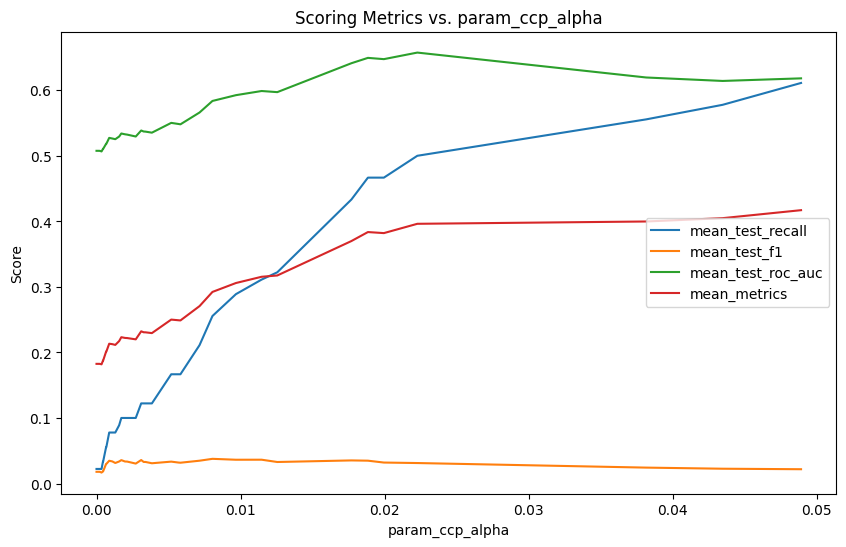

In [ ]:
scoring_metrics = ['mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc', 'mean_metrics']

fig, ax = plt.subplots(figsize=(10, 6))

for metric in scoring_metrics:
    ax.plot(results_df['param_ccp_alpha'], results_df[metric], label=metric)

ax.set_xlabel('param_ccp_alpha')
ax.set_ylabel('Score')
ax.set_title('Scoring Metrics vs. param_ccp_alpha')
ax.legend()
plt.show()

0.638624636926923


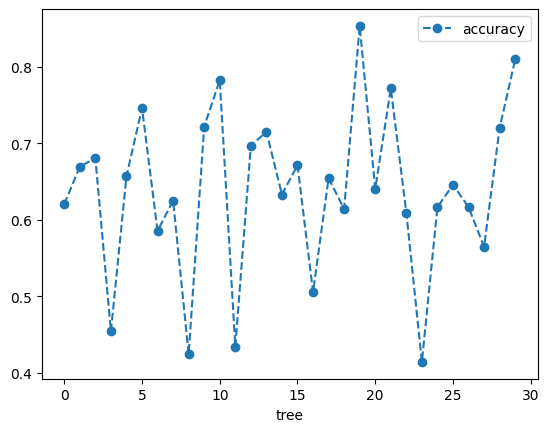

In [ ]:
# create the tree with ccp_alpha = optimal param
clf = DecisionTreeClassifier(random_state=1, class_weight='balanced', ccp_alpha=ccp_alphas[-1])

# the graph we drew suggested ONE value for alpha, but another set might suggested another optimal value...
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
df = pd.DataFrame(data={'tree': range(30), 'accuracy': scores})

# for instance, if we do this with 5-fold CV, see how the accuracy varies by applying the same alpha to all of them
df.plot(x='tree', y='accuracy', marker='o', linestyle='--')
print(scores.mean())


0.5791692197712418


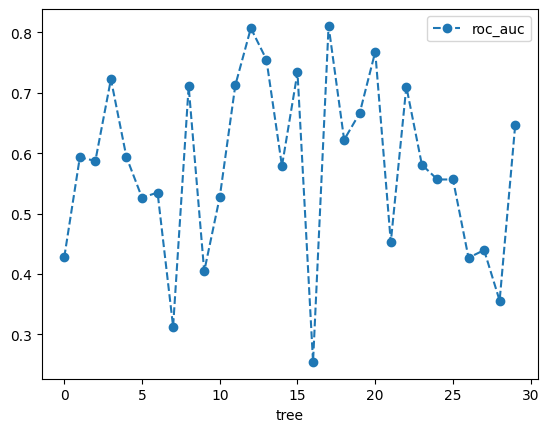

In [ ]:
scores = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
df = pd.DataFrame(data={'tree': range(30), 'roc_auc': scores})

df.plot(x='tree', y='roc_auc', marker='o', linestyle='--')
print(scores.mean())

In [ ]:
ideal_ccp_alpha = float(ccp_alphas[-1])
ideal_ccp_alpha

0.04890448379827538

## Build + Evaluate New Model

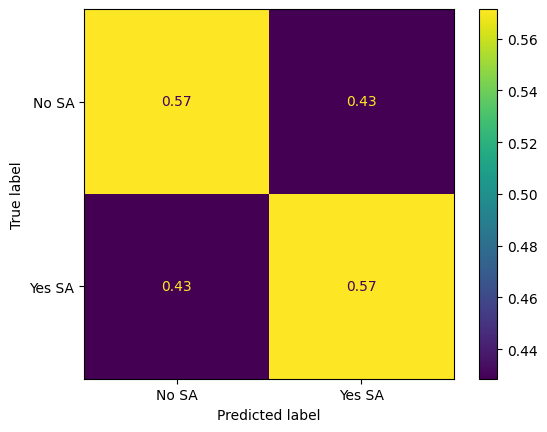

In [ ]:
# build and train new DT w/ optimal value for alpha
clf_dt_pruned = DecisionTreeClassifier(random_state=1, class_weight='balanced', ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned.fit(X_train_q, y_train)
ConfusionMatrixDisplay.from_estimator(clf_dt_pruned, X_valid_q, y_valid, normalize='true',
                                      display_labels=["No SA", "Yes SA"])

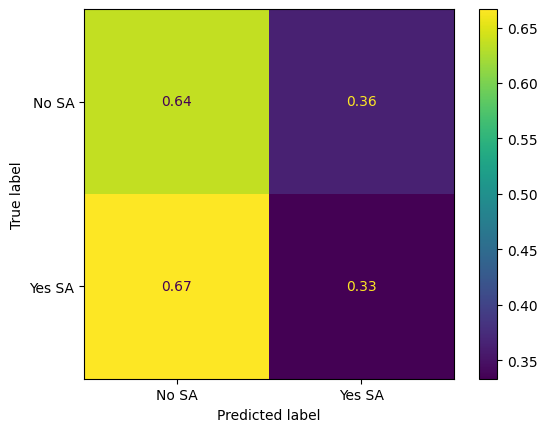

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf_dt_pruned, X_test_q, y_test, normalize='true',
                                      display_labels=["No SA", "Yes SA"])

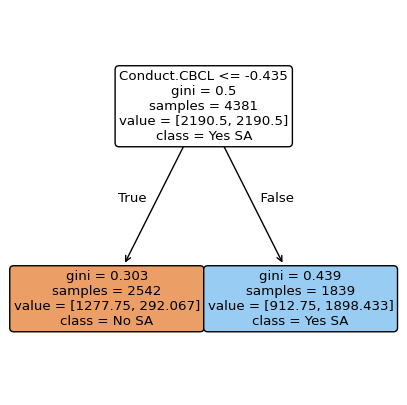

In [ ]:
# plot/draw the pruned tree
plt.figure(figsize=(5,5))
plt.title("Pruned Decision Tree")
plot_tree(clf_dt_pruned,
          feature_names=X_train.columns,
          class_names=["No SA", "Yes SA"],
          filled=True,
          rounded=True)
plt.show()

## Feature Importance

In [ ]:
feature_names_q = X_train_q.columns
importances_q = clf_dt_pruned.feature_importances_
feature_importance_q = pd.DataFrame(importances_q, index=feature_names_q, columns=['importances'])
feature_importance_q = feature_importance_q.sort_values('importances', ascending=False)

features_q = list(feature_importance_q[feature_importance_q['importances']>0].index)

## AUC ROC

In [ ]:
predict_proba = clf_dt_pruned.predict_proba(X_valid_q)
roc_auc_score(y_valid, predict_proba[:, 1])


0.5712973894792076

In [ ]:
predict_proba = clf_dt_pruned.predict_proba(X_test_q)
roc_auc_score(y_test, predict_proba[:, 1])

0.4848484848484848

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr2, tpr2, thresholds2 = roc_curve(y_test, predict_proba[:,1])
auc2 = auc(fpr2, tpr2)

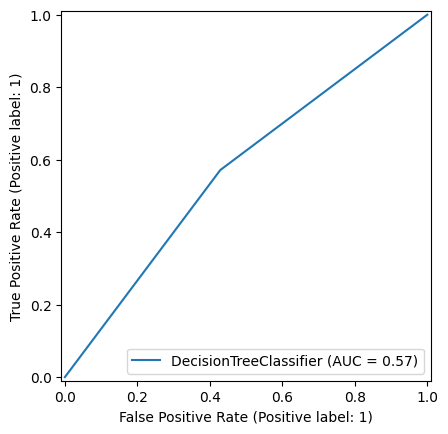

In [ ]:
metrics.RocCurveDisplay.from_estimator(clf_dt_pruned, X_valid_q, y_valid)

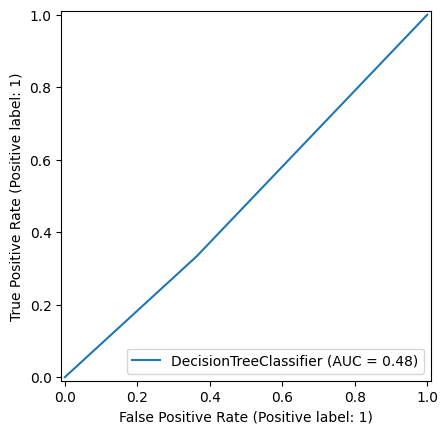

In [ ]:
metrics.RocCurveDisplay.from_estimator(clf_dt_pruned, X_test_q, y_test)

In [ ]:
predict = clf_dt_pruned.predict(X_valid_q)
print(metrics.classification_report(y_valid, predict, target_names=['No SA', 'Yes SA']))

              precision    recall  f1-score   support

       No SA       1.00      0.57      0.73      1089
      Yes SA       0.01      0.57      0.02         7

    accuracy                           0.57      1096
   macro avg       0.50      0.57      0.37      1096
weighted avg       0.99      0.57      0.72      1096



In [ ]:
predict = clf_dt_pruned.predict(X_test_q)
print(metrics.classification_report(y_test, predict, target_names=['No SA', 'Yes SA']))

              precision    recall  f1-score   support

       No SA       0.54      0.64      0.58        11
      Yes SA       0.43      0.33      0.38         9

    accuracy                           0.50        20
   macro avg       0.48      0.48      0.48        20
weighted avg       0.49      0.50      0.49        20



# **fMRI ONLY**

## Cost Complexity Pruning

### Visualizing Alpha Value

In [ ]:
path = clf.cost_complexity_pruning_path(X_train_mri, y_train) # determine values for alpha
ccp_alphas = path.ccp_alphas
# omit max value for alpha or else it would prune ALL leaves
ccp_alphas = ccp_alphas[:-1]

clf_dts = [] # create an array to put DTs into

# build a pruned tree for each value of alpha and store in the array
for ccp_alpha in ccp_alphas:
  clf = DecisionTreeClassifier(random_state=1, class_weight='balanced', ccp_alpha=ccp_alpha)
  clf.fit(X_train_mri, y_train)
  clf_dts.append(clf)
# print(ccp_alphas)

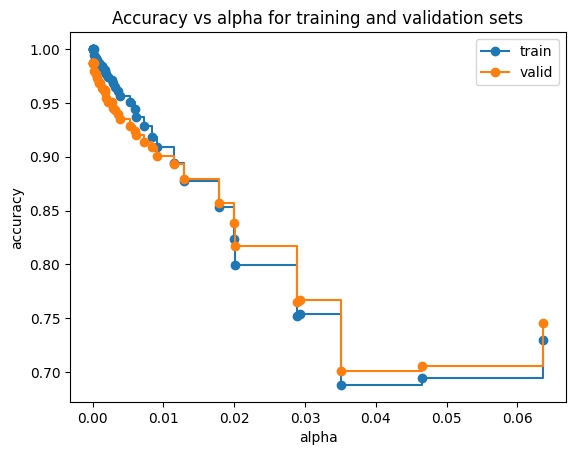

In [ ]:
# graph accuracy of the trees using training and testing dataset as a function of alpha
train_scores = [clf.score(X_train_mri, y_train) for clf in clf_dts]
valid_scores = [clf.score(X_valid_mri, y_valid) for clf in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validation sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker='o', label="valid", drawstyle="steps-post")
ax.legend()
plt.show()

### CV to Find Best Alpha

In [ ]:
# running this segment takes an extremely long time... will estimate using just a few values.
# ccp_alphas[30::]

param_grid = {'ccp_alpha': ccp_alphas[30::]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
optimal_params = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=1, class_weight='balanced'),
    param_grid = param_grid,
    scoring = ['recall', 'f1', 'roc_auc'],
    n_jobs=-1,
    cv=cv,
    verbose=2,
    refit='roc_auc')

optimal_params.fit(X_train_mri, y_train)

Fitting 30 folds for each of 9 candidates, totalling 270 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=1),
             n_jobs=-1,
             param_grid={'ccp_alpha': array([0.01295453, 0.01786472, 0.02001287, 0.02012064, 0.02891606,
       0.02923716, 0.03504755, 0.04657627, 0.06367025])},
             refit='roc_auc', scoring=['recall', 'f1', 'roc_auc'], verbose=2)

In [ ]:
results_df = pd.DataFrame(optimal_params.cv_results_)
results_df['mean_metrics'] = results_df[['mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc']].mean(axis=1)

scoring_df = ['param_ccp_alpha', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc', 'mean_metrics']
# results_df[scoring_df]
sorted_df = results_df[scoring_df].sort_values(by=['mean_metrics'], ascending=False)
sorted_df.head()

,param_ccp_alpha,mean_test_recall,mean_test_f1,mean_test_roc_auc,mean_metrics
8,0.063670,0.266667,0.009274,0.443061,0.239667
7,0.046576,0.222222,0.009358,0.438684,0.223421
1,0.017865,0.133333,0.014013,0.506499,0.217948
2,0.020013,0.133333,0.013208,0.501292,0.215944
3,0.020121,0.133333,0.013208,0.501139,0.215893


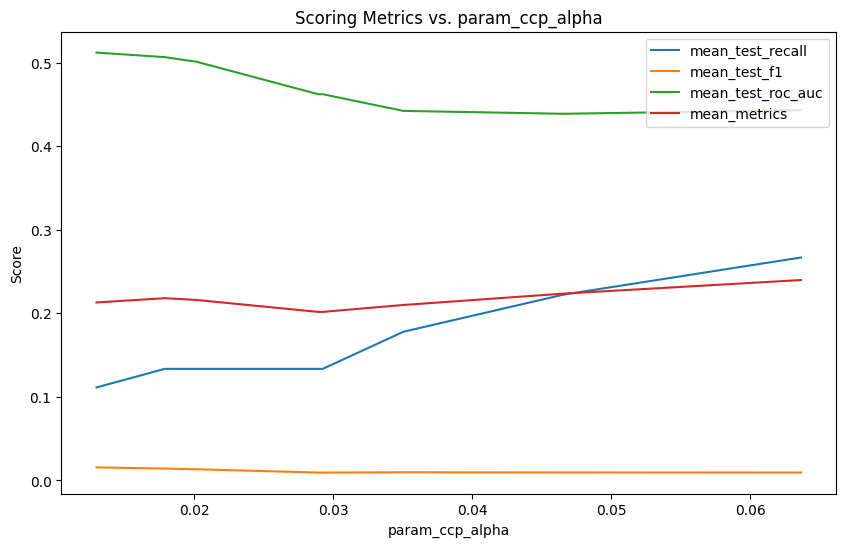

In [ ]:
scoring_metrics = ['mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc', 'mean_metrics']

fig, ax = plt.subplots(figsize=(10, 6))

for metric in scoring_metrics:
    ax.plot(results_df['param_ccp_alpha'], results_df[metric], label=metric)

ax.set_xlabel('param_ccp_alpha')
ax.set_ylabel('Score')
ax.set_title('Scoring Metrics vs. param_ccp_alpha')
ax.legend()
plt.show()

0.8946559868693205


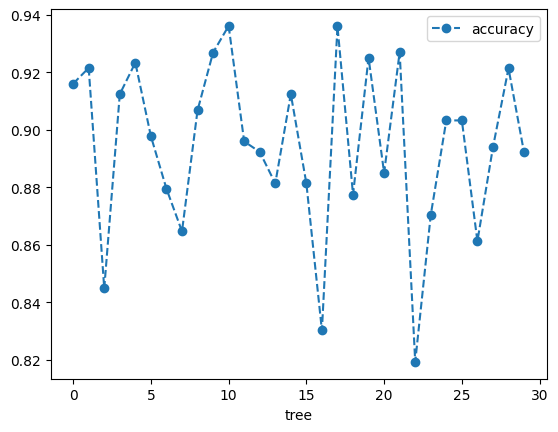

In [ ]:
# create the tree with ccp_alpha = optimal param
ideal_ccp_alpha = float(optimal_params.best_params_['ccp_alpha'])
clf = DecisionTreeClassifier(random_state=1, class_weight='balanced', ccp_alpha=ideal_ccp_alpha)

# the graph we drew suggested ONE value for alpha, but another set might suggested another optimal value...
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
df = pd.DataFrame(data={'tree': range(30), 'accuracy': scores})

# for instance, if we do this with 30-fold CV, see how the accuracy varies by applying the same alpha to all of them
df.plot(x='tree', y='accuracy', marker='o', linestyle='--')
print(scores.mean())


0.536077920751634


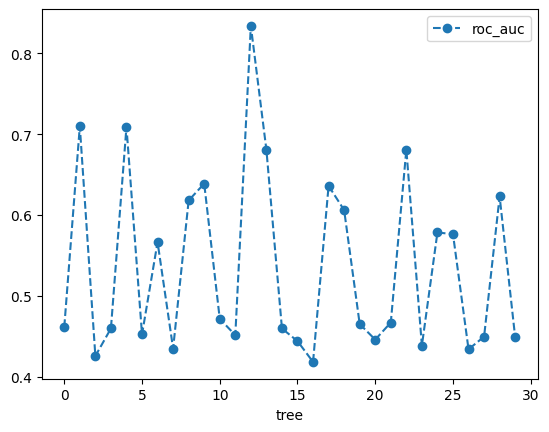

In [ ]:
scores = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
df = pd.DataFrame(data={'tree': range(30), 'roc_auc': scores})

df.plot(x='tree', y='roc_auc', marker='o', linestyle='--')
print(scores.mean())

## Build + Evaluate New Model

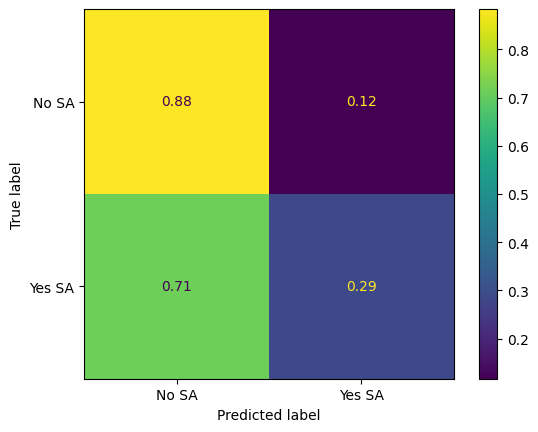

In [ ]:
# build and train new DT w/ optimal value for alpha
clf_dt_pruned = DecisionTreeClassifier(random_state=1, class_weight='balanced', ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned.fit(X_train_mri, y_train)
ConfusionMatrixDisplay.from_estimator(clf_dt_pruned, X_valid_mri, y_valid, normalize='true',
                                      display_labels=["No SA", "Yes SA"])

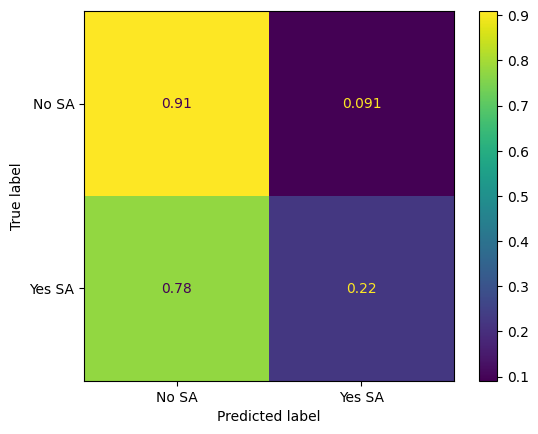

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf_dt_pruned, X_test_mri, y_test, normalize='true',
                                      display_labels=["No SA", "Yes SA"])

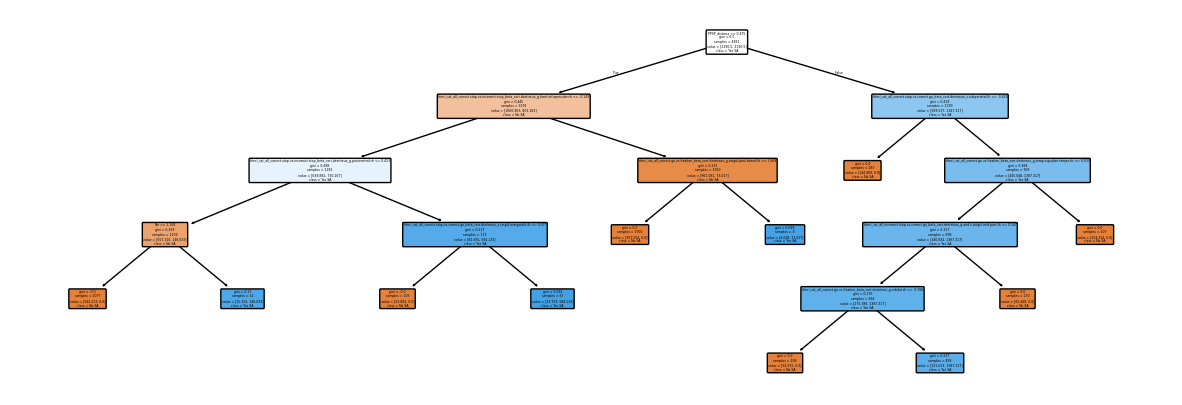

In [ ]:
# plot/draw the pruned tree
plt.figure(figsize=(15,5))
plt.title("Pruned Decision Tree")
plot_tree(clf_dt_pruned,
          feature_names=X_train.columns,
          class_names=["No SA", "Yes SA"],
          filled=True,
          rounded=True)
plt.show()

## Feature Importance

In [ ]:
feature_names_mri = X_train_mri.columns
importances_mri = clf_dt_pruned.feature_importances_
feature_importance_mri = pd.DataFrame(importances_mri, index=feature_names_mri, columns=['importances'])
feature_importance_mri = feature_importance_mri.sort_values('importances', ascending=False)

features_mri = list(feature_importance_mri[feature_importance_mri['importances']>0].index)
# feature_importance_mri.head()

## AUC ROC

In [ ]:
predict_proba = clf_dt_pruned.predict_proba(X_valid_mri)
roc_auc_score(y_valid, predict_proba[:, 1])

0.5808736717827626

In [ ]:
predict_proba = clf_dt_pruned.predict_proba(X_test_mri)
roc_auc_score(y_test, predict_proba[:, 1])

0.5656565656565656

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr3, tpr3, thresholds3 = roc_curve(y_test, predict_proba[:,1])
auc3 = auc(fpr3, tpr3)

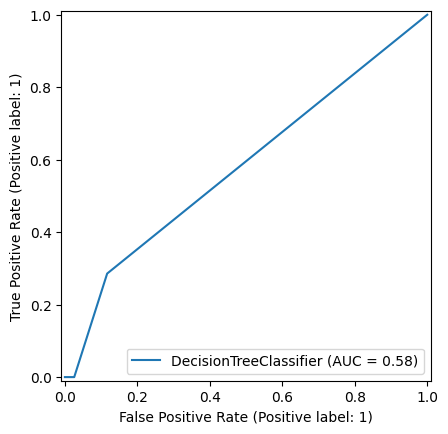

In [ ]:
metrics.RocCurveDisplay.from_estimator(clf_dt_pruned, X_valid_mri, y_valid)

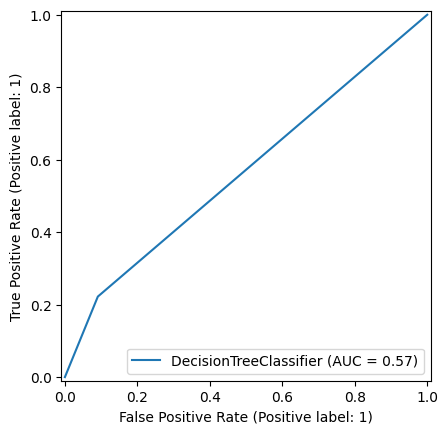

In [ ]:
metrics.RocCurveDisplay.from_estimator(clf_dt_pruned, X_test_mri, y_test)

In [ ]:
predict = clf_dt_pruned.predict(X_valid_mri)
print(metrics.classification_report(y_valid, predict, target_names=['No SA', 'Yes SA']))

              precision    recall  f1-score   support

       No SA       0.99      0.88      0.94      1089
      Yes SA       0.02      0.29      0.03         7

    accuracy                           0.88      1096
   macro avg       0.51      0.58      0.48      1096
weighted avg       0.99      0.88      0.93      1096



In [ ]:
predict = clf_dt_pruned.predict(X_test_mri)
print(metrics.classification_report(y_test, predict, target_names=['No SA', 'Yes SA']))

              precision    recall  f1-score   support

       No SA       0.59      0.91      0.71        11
      Yes SA       0.67      0.22      0.33         9

    accuracy                           0.60        20
   macro avg       0.63      0.57      0.52        20
weighted avg       0.62      0.60      0.54        20



# **Final AUC ROC Curve Compare**

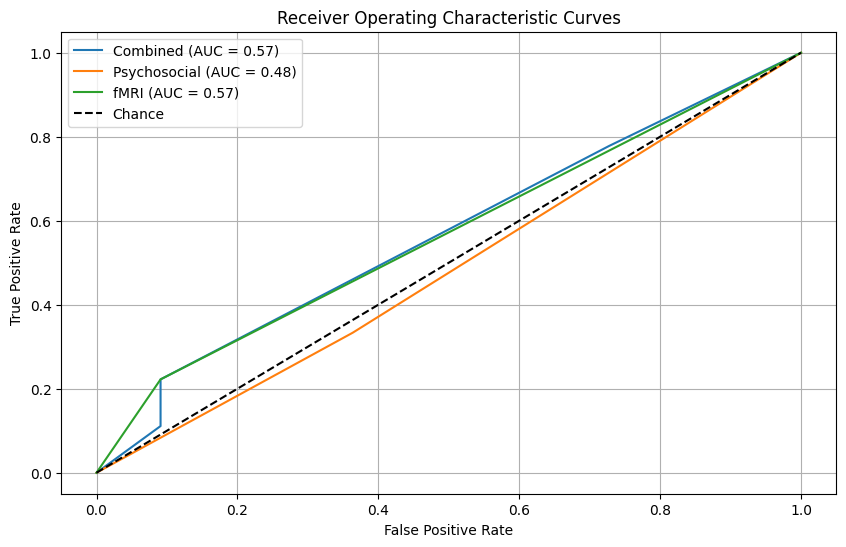

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(fpr1, tpr1, label=f'Combined (AUC = {auc1:.2f})')
plt.plot(fpr2, tpr2, label=f'Psychosocial (AUC = {auc2:.2f})')
plt.plot(fpr3, tpr3, label=f'fMRI (AUC = {auc3:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.legend()
plt.grid(True)
plt.show()